In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns

In [2]:
sns.set_theme()

We calculate daily stock returns in `Analyzing_Bear_Markets.ipynb` and save them to `sp500.csv`.
This file also includes the level of the S&P 500 index as column `^GSPC`.
To avoid imprecise correlation and Capital Asset Pricing Model (CAPM) beta estimates, we can remove months with fewer than 10 returns.
We could also filter these months with few returns when we calculate correlations and CAPM betas.

In [5]:
sp500 = (
    pd.read_csv(
        filepath_or_buffer='sp500.csv',
        parse_dates=['Date'],
        index_col=['Date']
    )
    .rename_axis(columns='Ticker')
)
gspc = sp500[['^GSPC']]
del sp500['^GSPC']

# keep only months with at least 10 returns for each stock
sp500 = (
    sp500
    .stack()
    .loc[
        (sp500.resample('M').transform('count') >= 10).stack()
    ]
    .unstack()
)

We need Fama and French factor data to calculate CAPM betas.


In [6]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .div(100)
    .rename_axis(columns='Factor')
)

<ipython-input-6-f6fa8e73ace0>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


We calculate excess returns here to simplify our CAPM beta calculations later.

In [7]:
sp500_rf = (
    sp500
    .sub(ff['RF'], axis=0)
    .join(ff[['Mkt-RF']])
    .loc['1980':'2023']
)

#Functions
The following function calculates bear markets based on declines and recoveries given with the `down` and `up` arguments.

In [8]:
def calc_bear(df, col, down=0.2, up=0.2):
    df_copy = df.copy()
    down = 1 - down
    up = 1 + up

    bear = df_copy['Bear'] = False
    low = high = df_copy[col].iloc[0]

    for i, x in df_copy[col].items():
        if not bear and (x < down*high):
            bear = df_copy.at[i, 'Bear'] = True
            low = high = x
        elif bear and (x > up*low):
            bear = df_copy.at[i, 'Bear'] = False
            low = high = x
        else:
            df_copy.at[i, 'Bear'] = bear
            low = min(x, low)
            high = max(x, high)

    return df_copy

We resample the bear market data to combine it with the monthly and quarterly correlations.
We consider a month or quarter and bear market if it has at least `n` bear days.

In [9]:
def resample_bear(df, freq, n):
    return (
        df
        .resample(freq)
        ['Bear']
        .sum()
        .gt(n - 1)
        .astype(bool)
        .to_frame('Bear')
    )


The following function calculates the unique pairwise correlations each month or quarter.

In [10]:
def calc_corr(df, freq):
    return (
        df
        .groupby(pd.Grouper(freq=freq))
        .corr()
        .stack()
        .rename_axis(index=['Date', 'T1', 'T2'])
        .to_frame('corr')
        .reset_index()
        .query('T1 < T2')
        .set_index('Date')
    )

The following function calculates the CAPM beta for each stock each month or quarter.^[After we discussed this solution in class, I tweaked `calc_beta()` so it drops the "Mkt-RF" beta inside the function instead of outside the function to match the style of `calc_corr()`.]


In [11]:
def calc_beta(df, freq):
    grouped = df.groupby(pd.Grouper(freq=freq))
    top = grouped.cov()['Mkt-RF']
    bot = grouped['Mkt-RF'].var()
    return (
        top
        .div(bot)
        .rename_axis(index=['Date', 'T1'])
        .to_frame('beta')
        .reset_index()
        .query('T1 != "Mkt-RF"')
    )

#Calculations
First, we calculate all the bear markets and resample them to align with the monthly and quarterly data.


In [12]:
bear_d = gspc.pipe(calc_bear, '^GSPC')
bear_m = bear_d.pipe(resample_bear, freq='M', n=10)
bear_q = bear_d.pipe(resample_bear, freq='Q', n=30)


Here are the bear markets.

In [13]:
bear_d_p1 = bear_d['Bear'].astype(int).diff().loc['1980':'2023'].pipe(lambda x: x[x == +1])
bear_d_m1 = bear_d['Bear'].astype(int).diff().loc['1980':'2023'].pipe(lambda x: x[x == -1])

n = 47
print('=' * n)
print('List of Declines and Recoveries (Daily)')
print('-' * n)
for p1, m1 in zip(bear_d_p1.index, bear_d_m1.index):
    print(f'Start on {p1:%b %d, %Y}, and Stop on {m1:%b %d, %Y}')
print('=' * n)

List of Declines and Recoveries (Daily)
-----------------------------------------------
Start on Feb 22, 1982, and Stop on Sep 14, 1982
Start on Oct 19, 1987, and Stop on Mar 08, 1988
Start on Mar 12, 2001, and Stop on Dec 05, 2001
Start on Jul 10, 2002, and Stop on Aug 22, 2002
Start on Jul 09, 2008, and Stop on Dec 08, 2008
Start on Feb 23, 2009, and Stop on Mar 23, 2009
Start on Mar 12, 2020, and Stop on Apr 08, 2020
Start on Jun 13, 2022, and Stop on Jun 08, 2023


Another intrepration is to calculate crises using only end-of-month prices.


In [14]:
bear_m_alt = gspc.resample('M').last().pipe(calc_bear, '^GSPC')

bear_m_alt_p1 = bear_m_alt['Bear'].astype(int).diff().loc['1980':'2023'].pipe(lambda x: x[x == +1])
bear_m_alt_m1 = bear_m_alt['Bear'].astype(int).diff().loc['1980':'2023'].pipe(lambda x: x[x == -1])

n = 47
print('=' * n)
print('List of Declines and Recoveries (Monthly)')
print('-' * n)
for p1, m1 in zip(bear_m_alt_p1.index, bear_m_alt_m1.index):
    print(f'Start on {p1:%b %d, %Y}, and Stop on {m1:%b %d, %Y}')
print('=' * n)

List of Declines and Recoveries (Monthly)
-----------------------------------------------
Start on Mar 31, 1982, and Stop on Oct 31, 1982
Start on Oct 31, 1987, and Stop on Oct 31, 1988
Start on Mar 31, 2001, and Stop on Jul 31, 2003
Start on Sep 30, 2008, and Stop on May 31, 2009
Start on Mar 31, 2020, and Stop on Jul 31, 2020
Start on Jun 30, 2022, and Stop on Jun 30, 2023


...or end-of-quarter prices

In [15]:
bear_q_alt = gspc.resample('Q').last().pipe(calc_bear, '^GSPC')

bear_q_alt_p1 = bear_q_alt['Bear'].astype(int).diff().loc['1980':'2023'].pipe(lambda x: x[x == +1])
bear_q_alt_m1 = bear_q_alt['Bear'].astype(int).diff().loc['1980':'2023'].pipe(lambda x: x[x == -1])

n = 47
print('=' * n)
print('List of Declines and Recoveries (Quarterly)')
print('-' * n)
for p1, m1 in zip(bear_q_alt_p1.index, bear_q_alt_m1.index):
    print(f'Start on {p1:%b %d, %Y}, and Stop on {m1:%b %d, %Y}')
print('=' * n)

List of Declines and Recoveries (Quarterly)
-----------------------------------------------
Start on Dec 31, 1987, and Stop on Jun 30, 1989
Start on Mar 31, 2001, and Stop on Sep 30, 2003
Start on Sep 30, 2008, and Stop on Sep 30, 2009
Start on Mar 31, 2020, and Stop on Sep 30, 2020
Start on Jun 30, 2022, and Stop on Jun 30, 2023


 We can also calculate S&P 500 drawdowns to provide another definition of crises.
Here, we use a three-year window to approximate our bear market definition, but the details will not affect our conclusions much.


In [16]:
dd_d = gspc.div(gspc.rolling('1095d').max())['^GSPC'].rename('Drawdown')
dd_m = dd_d.resample('M').last().loc['1980':'2023']

Second, we calculate the means of all the unique pairwise correlations.
Here, we only calculate the means for simplicity, but our results are similar if we calculate medians instead.
We can also calculate minimums and maximums to help us troubleshoot.

In [17]:
corr_m = sp500.pipe(calc_corr, freq='M').groupby('Date')['corr'].mean().rename('Monthly')
corr_q = sp500.pipe(calc_corr, freq='Q').groupby('Date')['corr'].mean().rename('Quarterly')


Finally, we calculate the means of all the CAPM betas.


In [18]:
sp500_rf.loc['1980-01'].pipe(calc_beta, freq='M')

,Date,T1,beta
0,1980-01-31,A,NaN
1,1980-01-31,AAL,NaN
2,1980-01-31,AAPL,NaN
3,1980-01-31,ABBV,NaN
4,1980-01-31,ABNB,NaN
...,...,...,...
498,1980-01-31,YUM,NaN
499,1980-01-31,ZBH,NaN
500,1980-01-31,ZBRA,NaN
501,1980-01-31,ZION,NaN


from matplotlib import pyplot as plt
_df_0['beta'].plot(kind='hist', bins=20, title='beta')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['beta']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('beta')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['beta'].plot(kind='line', figsize=(8, 4), title='beta')
plt.gca().spines[['top', 'right']].set_visible(False)

In [19]:
beta_m = sp500_rf.pipe(calc_beta, freq='M').groupby('Date')['beta'].mean().rename('Monthly')
beta_q = sp500_rf.pipe(calc_beta, freq='Q').groupby('Date')['beta'].mean().rename('Quarterly')


# Analysis
We see that correlations spike during bear markets for monthly and quarterly correlations.
The spikes are not to one, so the cliche that "correlations go to one" during crises is dramatic but is directionally true.


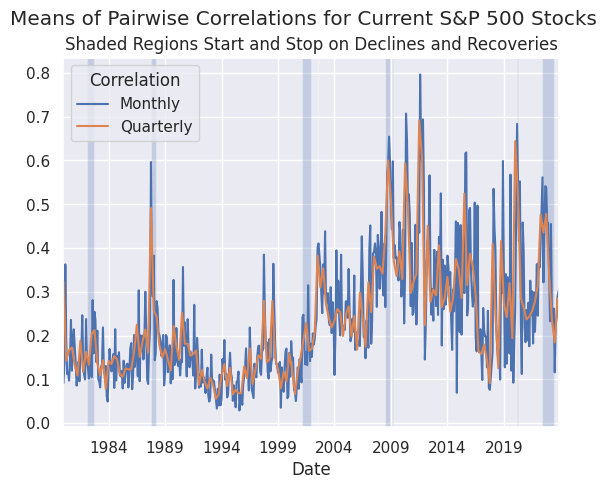

In [20]:
fig, ax = plt.subplots()
corr_m.plot(ax=ax)
corr_q.plot(ax=ax)
plt.legend(title='Correlation')
for p1, m1 in zip(bear_d_p1.index, bear_d_m1.index):
    ax.axvspan(xmin=p1, xmax=m1, alpha=0.25)
plt.suptitle('Means of Pairwise Correlations for Current S&P 500 Stocks')
plt.title('Shaded Regions Start and Stop on Declines and Recoveries')
plt.show()

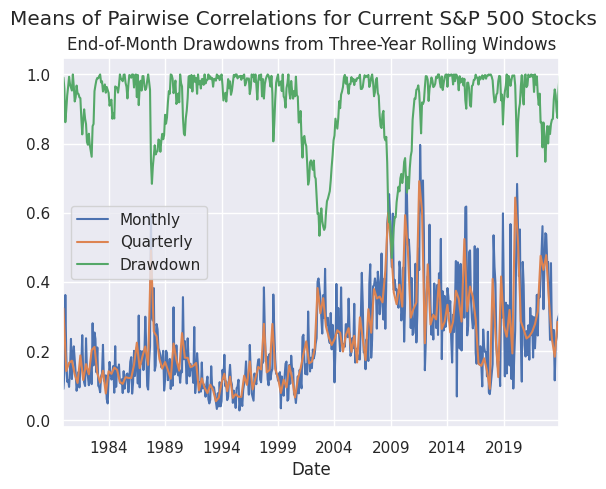

In [21]:
fig, ax = plt.subplots()
corr_m.plot(ax=ax)
corr_q.plot(ax=ax)
dd_m.plot(ax=ax)
plt.legend()
plt.suptitle('Means of Pairwise Correlations for Current S&P 500 Stocks')
plt.title('End-of-Month Drawdowns from Three-Year Rolling Windows')
plt.show()

In [22]:
pd.concat([corr_m, corr_q, dd_m], axis=1).corr()

,Monthly,Quarterly,Drawdown
Monthly,1.000000,0.900692,-0.422175
Quarterly,0.900692,1.000000,-0.468241
Drawdown,-0.422175,-0.468241,1.000000


We *do not* see this pattern for CAPM betas!

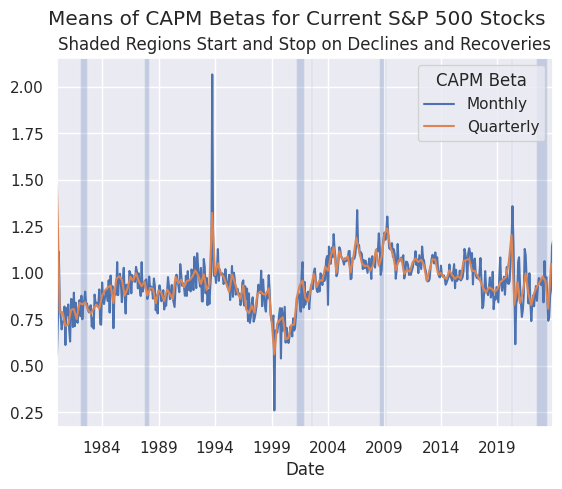

In [23]:
fig, ax = plt.subplots()
beta_m.plot(ax=ax)
beta_q.plot(ax=ax)
plt.legend(title='CAPM Beta')
for p1, m1 in zip(bear_d_p1.index, bear_d_m1.index):
    ax.axvspan(xmin=p1, xmax=m1, alpha=0.25)
plt.suptitle('Means of CAPM Betas for Current S&P 500 Stocks')
plt.title('Shaded Regions Start and Stop on Declines and Recoveries')
plt.show()


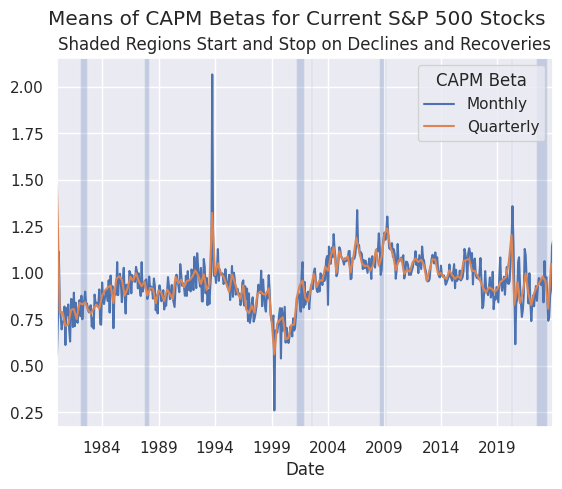

In [24]:
fig, ax = plt.subplots()
beta_m.plot(ax=ax)
beta_q.plot(ax=ax)
plt.legend(title='CAPM Beta')
for p1, m1 in zip(bear_d_p1.index, bear_d_m1.index):
    ax.axvspan(xmin=p1, xmax=m1, alpha=0.25)
plt.suptitle('Means of CAPM Betas for Current S&P 500 Stocks')
plt.title('Shaded Regions Start and Stop on Declines and Recoveries')
plt.show()

Finally, bar plots provide another perspective on these relations.
The vertical black bars indicate 95% confidence intervals.


In [25]:
df_m = bear_m.copy()
df_m['Correlation'] = corr_m
df_m['CAPM Beta'] = beta_m

In [26]:
df_q = bear_q.copy()
df_q['Correlation'] = corr_q
df_q['CAPM Beta'] = beta_q

In [27]:
df = (
    pd.concat(
        objs=[df_m.dropna(), df_q.dropna()],
        keys=['Monthly', 'Quarterly'],
        names=['Frequency']
    )
    .reset_index()
    .melt(
        id_vars=['Frequency', 'Date', 'Bear'],
        var_name='Statistic',
        value_name='Value'
    )
)

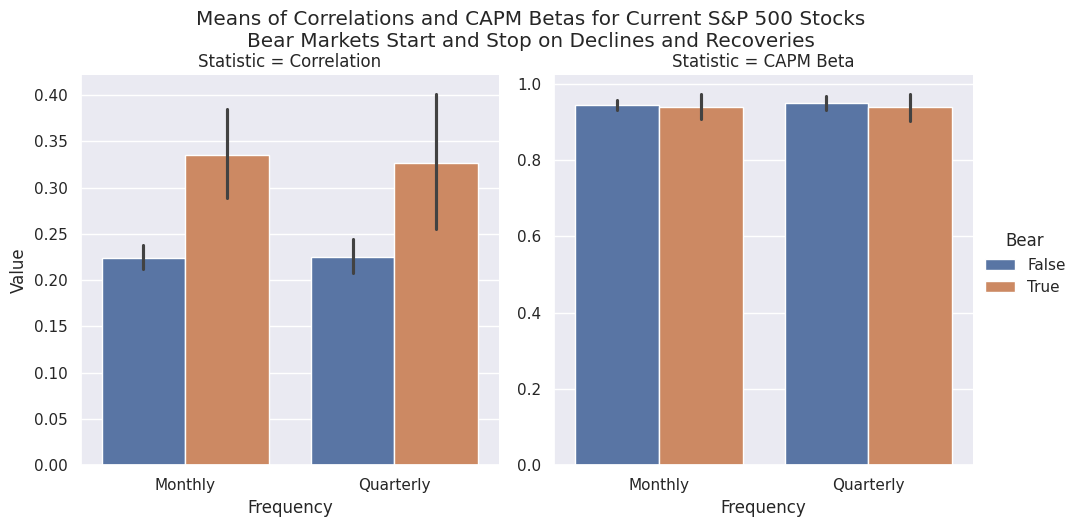

In [28]:
sns.catplot(
    data=df,
    x='Frequency',
    y='Value',
    col='Statistic',
    hue='Bear',
    kind='bar',
    sharey=False
)
plt.suptitle(
    t='Means of Correlations and CAPM Betas for Current S&P 500 Stocks' +
    '\n' +
    'Bear Markets Start and Stop on Declines and Recoveries',
    y=1.05
)
plt.show()